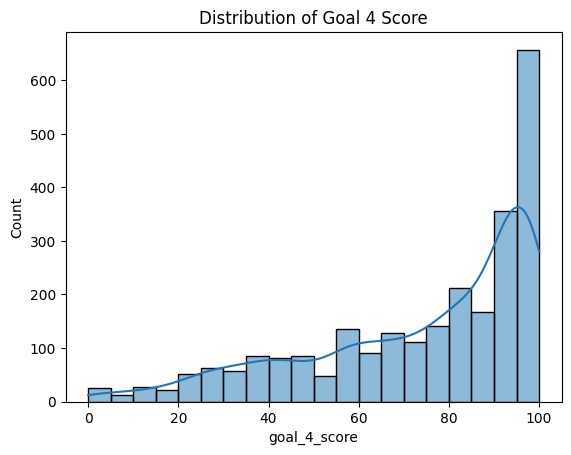

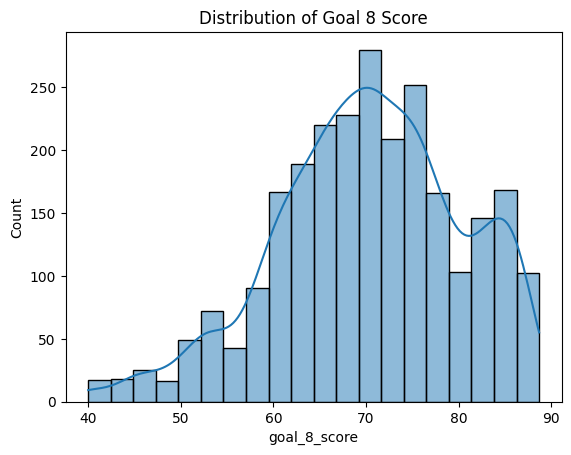

Goal 4 Skewness: -0.9703004139790091, Kurtosis: -0.06397082819799449
Goal 8 Skewness: -0.37739419872221236, Kurtosis: -0.10193820279929389
Shapiro-Wilk Test for Goal 4: Statistic=0.8704198002815247, p-value=8.172372643942333e-42
Shapiro-Wilk Test for Goal 8: Statistic=0.9805911183357239, p-value=3.225045686626859e-18
KS Test for Goal 4: Statistic=0.9919548709209645, p-value=0.0
KS Test for Goal 8: Statistic=1.0, p-value=0.0
Plastic Waste Category: recycled
Skewness: 0.8255825764948789, Kurtosis: -0.06916111699885752
Shapiro-Wilk Test: Statistic=0.9299833178520203, p-value=4.8287008370955775e-33
--------------------------------------------------
Plastic Waste Category: incinerated
Skewness: 1.0132581711996114, Kurtosis: -0.26765403031422474
Shapiro-Wilk Test: Statistic=0.7706642746925354, p-value=0.0
--------------------------------------------------
Plastic Waste Category: littered
Skewness: 0.17740670053195418, Kurtosis: -1.061642277470865
Shapiro-Wilk Test: Statistic=0.90268123149871

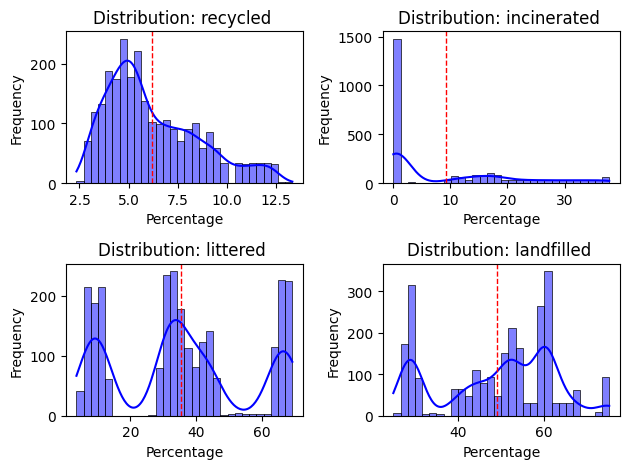

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import statsmodels.api as sm
from scipy.stats import pearsonr, ttest_ind, skew, kurtosis, shapiro, kstest ,spearmanr, kendalltau, fisher_exact
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Dataset from kaggle:
#df3 and df4 are same datasets, therefore, matching countries among 3 different datasets
#were extracted as'country_groups' and 'continent_mapping' shows. 
df3 = pd.read_csv("3- share-plastic-fate.csv")
df4 = pd.read_csv("4- mismanaged-plastic-waste-per-capita.csv")
df_sdg= pd.read_csv('sdg_index_2000-2022.csv')
dfgdp = pd.read_csv('gdp.csv')

df_sdg["year"] = df_sdg["year"].round().astype(int)  # Rounds and converts to int
df_filtered = df_sdg[(df_sdg["year"] >= 2000) & (df_sdg["year"] <= 2020)].copy()
df_sdg = df_sdg[df_sdg["year"] % 1 == 0]  


columns_to_keep = ['Country Name', 'Code'] + [str(year) for year in range(2000, 2021)]
filtered_dfgdp = dfgdp[columns_to_keep]
output_file_path = 'filtered_dfgdp_2000_2020.csv' 
filtered_dfgdp.to_csv(output_file_path, index=False)
gdp = pd.read_csv('filtered_dfgdp_2000_2020.csv')



country_groups = {
    "China": ["China"],
    "India": ["India"],
    "Asia (excl. China and India)": [
        'Bangladesh', 'Brunei', 'Cambodia', 'Hong Kong', 'Indonesia', 'Japan', 
        'Kazakhstan', 'Korea, Rep.', 'Malaysia', 'Maldives', 'Myanmar', 'Pakistan', 
        'Philippines', 'Singapore', 'Sri Lanka', 'Thailand', 'Vietnam'
    ],
    "Oceania": [
        'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'New Zealand', 'Palau', 
        'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Timor-Leste'
    ],
    "United States": ["United States"],
    "Americas (excl. USA)": [
        'Antigua and Barbuda', 'Argentina', 'Barbados', 'Belize', 'Brazil', 'Canada', 
        'Chile', 'Colombia', 'Costa Rica', 'Dominica', 'Dominican Republic', 'Ecuador', 
        'El Salvador', 'Grenada', 'Guatemala', 'Guyana', 'Honduras', 'Jamaica', 
        'Mexico', 'Panama', 'Peru', 'Puerto Rico', 'Suriname', 'Trinidad and Tobago', 
        'Uruguay', 'Venezuela', 'Bahamas', 'Haiti', 'Nicaragua', 'Saint Kitts and Nevis', 
        'Saint Lucia', 'Saint Vincent and the Grenadines', 'Sao Tome and Principe'
    ],
    "Middle East & North Africa": [
        'Algeria', 'Bahrain', 'Cyprus', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 
        'Kuwait', 'Lebanon', 'Libya', 'Morocco', 'Oman', 'Palestine', 'Qatar', 
        'Saudi Arabia', 'Sudan', 'Syria', 'Tunisia', 'Turkey', 'United Arab Emirates', 'Yemen'
    ],
    "Sub-Saharan Africa": [
        'Benin', 'Burkina Faso', 'Cameroon', 'Gabon', 'Ghana', 'Kenya', 'Lesotho', 
        'Liberia', 'Madagascar', 'Mauritania', 'Nigeria', 'Senegal', 'Seychelles', 
        'Sierra Leone', 'Somalia', 'South Africa', 'Togo', 'Zimbabwe', 'Angola', 'Comoros', 
        'Congo', 'Ivory Coast', 'Democratic Republic of the Congo', 'Djibouti', 
        'Equatorial Guinea', 'Eritrea', 'Gambia', 'Guinea', 'Guinea-Bissau', 
        'Mozambique', 'Namibia', 'Tanzania'
    ],
    "Europe": [
        'Albania', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Denmark', 
        'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Iceland', 'Ireland', 
        'Italy', 'Latvia', 'Lithuania', 'Malta', 'Monaco', 'Netherlands', 'Norway', 'Poland', 
        'Portugal', 'Romania', 'Russia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 
        'Ukraine', 'United Kingdom', 'Montenegro'
    ]
}


continent_mapping = {
    'CHN': 'China',
    'IND': 'India',
    'USA': 'United States',
    **{code: 'Asia (excl. China and India)' for code in ['BGD', 'BRN', 'KHM', 'HKG', 'IDN', 'JPN', 'KAZ', 'MYS',
        'MDV', 'MMR', 'PRK', 'PAK', 'PHL', 'SGP', 'KOR', 'LKA', 'THA', 'VNM']},
    **{code: 'Oceania' for code in ['AUS', 'FJI', 'KIR', 'MHL', 'NZL', 'PLW', 'PNG', 'WSM', 'SLB', 'TON', 'TLS']},
    **{code: 'Americas (excl. USA)' for code in ['ATG', 'ARG', 'BRB', 'BLZ', 'BRA', 'CAN', 'CHL', 'COL', 'CRI', 'DMA',
        'DOM', 'ECU', 'SLV', 'GRD', 'GTM', 'GUY', 'HND', 'JAM', 'MEX', 'PAN', 'PER', 'PRI', 'SUR', 'TTO', 'URY', 'VEN',
        'BHS', 'HTI', 'NIC', 'KNA', 'LCA', 'VCT', 'STP']},
    **{code: 'Middle East & North Africa' for code in ['DZA', 'BHR', 'CYP', 'EGY', 'IRN', 'IRQ', 'ISR', 'JOR', 'KWT',
        'LBN', 'LBY', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU', 'SDN', 'SYR', 'TUN', 'TUR', 'ARE', 'YEM']},
    **{code: 'Sub-Saharan Africa' for code in ['BEN', 'BFA', 'CMR', 'GAB', 'GHA', 'KEN', 'LSO', 'LBR', 'MDG', 'MRT',
        'NGA', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'TGO', 'ZWE', 'AGO', 'COM', 'COG', 'CIV', 'COD', 'DJI', 'GNQ', 'ERI',
        'GMB', 'GIN', 'GNB', 'MOZ', 'NAM', 'TZA']},
    **{code: 'Europe' for code in ['ALB', 'BEL', 'BIH', 'BGR', 'HRV', 'DNK', 'EST', 'FIN', 'FRA', 'GEO', 'DEU', 'GRC',
        'ISL', 'IRL', 'ITA', 'LVA', 'LTU', 'MLT', 'MCO', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'ESP',
        'SWE', 'UKR', 'GBR', 'MNE']}
}


df_sdg['continent'] = df_sdg['country_code'].map(continent_mapping).fillna('Others')
df_sdg.to_csv("sdgupdated_file.csv", index=False)

df_sdg["year"] = df_sdg["year"].astype(int)
df_sdg["country_code"] = df_sdg["country_code"].astype(str)

#Changing the name of the column to merge df3 to df_sdg 
plastic_df = df3.rename(columns={
    'Code':'country_code',
    'Year': 'year',
    'Entity':'continent',
    'Share of waste recycled from total regional waste': 'recycled', 
    'Share of waste incinerated from total regional waste': 'incinerated',
    'Share of littered and mismanaged from total regional waste': 'littered', 
    'Share of waste landfilled from total regional waste': 'landfilled'}) 


waste_categories = ['recycled', 'incinerated', 'littered', 'landfilled']

plastic_df["year"] = plastic_df["year"].astype(int)
plastic_df["country_code"] = plastic_df["country_code"].astype(str)
merged_df = pd.merge(df_sdg, plastic_df, on=['continent',"year"], how="inner")


#Checking distribution of goal 4 and goal 8
sns.histplot(merged_df["goal_4_score"], kde=True, bins=20)
plt.title("Distribution of Goal 4 Score")
plt.show()

sns.histplot(merged_df["goal_8_score"], kde=True, bins=20)
plt.title("Distribution of Goal 8 Score")
plt.show()

# Calculate skewness & kurtosis 
goal4_skew = skew(merged_df["goal_4_score"])
goal8_skew = skew(merged_df["goal_8_score"])
goal4_kurt = kurtosis(merged_df["goal_4_score"])
goal8_kurt = kurtosis(merged_df["goal_8_score"])

print(f"Goal 4 Skewness: {goal4_skew}, Kurtosis: {goal4_kurt}")
print(f"Goal 8 Skewness: {goal8_skew}, Kurtosis: {goal8_kurt}")

#Normality Tests (Shapiro-Wilk & KS Test)
shapiro_test_goal4 = shapiro(merged_df["goal_4_score"])
shapiro_test_goal8 = shapiro(merged_df["goal_8_score"])

print(f"Shapiro-Wilk Test for Goal 4: Statistic={shapiro_test_goal4.statistic}, p-value={shapiro_test_goal4.pvalue}")
print(f"Shapiro-Wilk Test for Goal 8: Statistic={shapiro_test_goal8.statistic}, p-value={shapiro_test_goal8.pvalue}")

ks_test_goal4 = kstest(merged_df["goal_4_score"], 'norm')
ks_test_goal8 = kstest(merged_df["goal_8_score"], 'norm')

print(f"KS Test for Goal 4: Statistic={ks_test_goal4.statistic}, p-value={ks_test_goal4.pvalue}")
print(f"KS Test for Goal 8: Statistic={ks_test_goal8.statistic}, p-value={ks_test_goal8.pvalue}")

#df3 skewness
for category in waste_categories:
    skewness = skew(merged_df[category])
    kurt = kurtosis(merged_df[category])
    shapiro_test = shapiro(merged_df[category])

    print(f"Plastic Waste Category: {category}")
    print(f"Skewness: {skewness}, Kurtosis: {kurt}")
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
    print("-" * 50)
    
for i, category in enumerate(waste_categories, 1):
    plt.subplot(2, 2, i)
    sns.histplot(merged_df[category], kde=True, bins=30, color="blue")
    plt.axvline(merged_df[category].mean(), color='red', linestyle='dashed', linewidth=1)  # Mean line
    plt.title(f"Distribution: {category} ")
    plt.xlabel("Percentage")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Median Scores Per Region:
                              goal_4_score  goal_8_score
region                                                  
Americas (excl. USA)                 83.50          70.5
Asia (excl. China and India)         90.60          72.9
China                                99.10          74.5
Europe                               96.60          80.8
India                                74.30          66.2
Middle East & North Africa           84.60          69.9
Oceania                              74.85          80.8
Other                                70.55          68.0
Sub-Saharan Africa                   41.30          63.8
United States                        94.20          82.5

Pearson Correlation: 0.6667, p-value: 0.03527


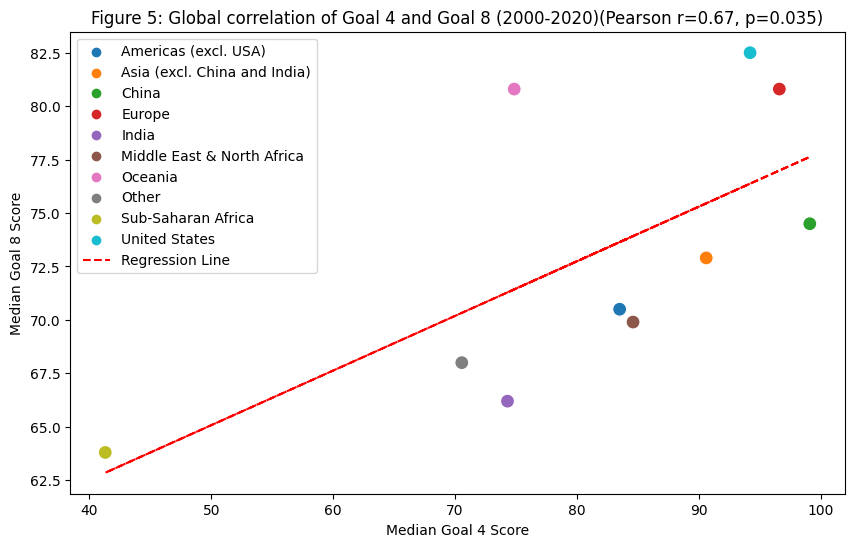

In [13]:
#Visualise the data of goal 4 and goal 8 with linear regression for an overview.
def categorize_country(country):
    for group, countries in country_groups.items():
        if country in countries:
            return group
    return "Other"

df_filtered["region"] = df_filtered["country"].apply(categorize_country)


median_scores = df_filtered.groupby("region")[["goal_4_score", "goal_8_score"]].median()


X = median_scores[["goal_4_score"]].values.reshape(-1, 1)
y = median_scores["goal_8_score"].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)


pearson_corr, p_value = pearsonr(median_scores["goal_4_score"], median_scores["goal_8_score"])


plt.figure(figsize=(10, 6))
sns.scatterplot(x=median_scores["goal_4_score"], y=median_scores["goal_8_score"], hue=median_scores.index, s=100)
plt.plot(median_scores["goal_4_score"], y_pred, color='red', linestyle='--', label='Regression Line')
plt.xlabel("Median Goal 4 Score")
plt.ylabel("Median Goal 8 Score")
plt.title(f"Figure 5: Global correlation of Goal 4 and Goal 8 (2000-2020)(Pearson r={pearson_corr:.2f}, p={p_value:.2g})")
plt.legend()
plt.grid(False)

print("Median Scores Per Region:")
print(median_scores)
print(f"\nPearson Correlation: {pearson_corr:.4f}, p-value: {p_value:.4g}")

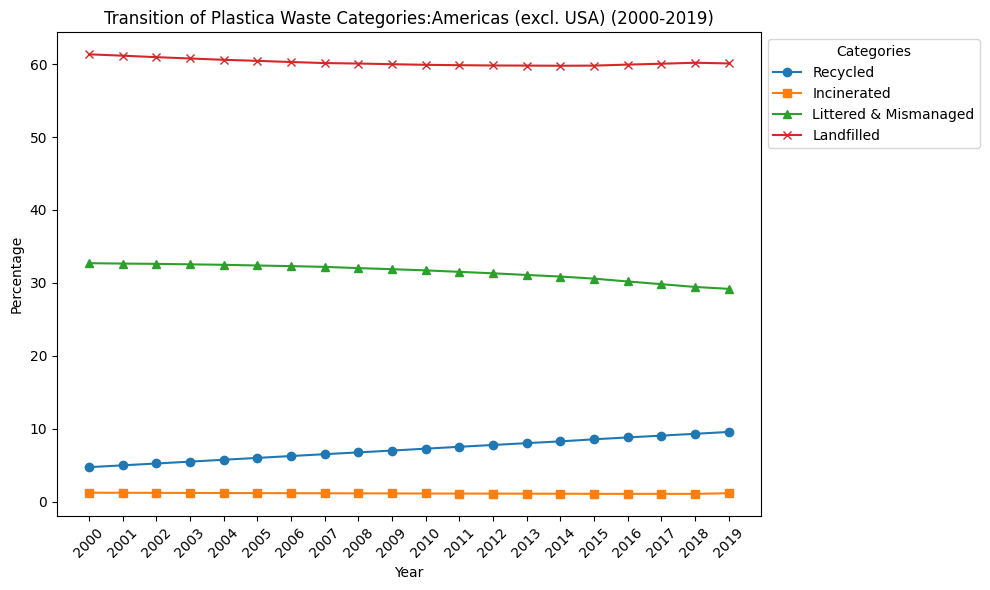

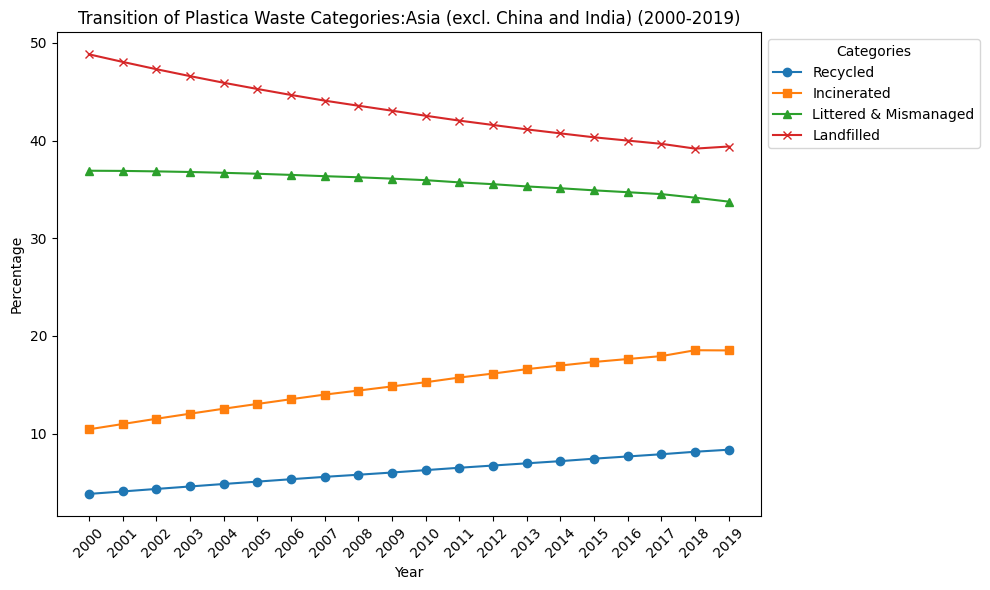

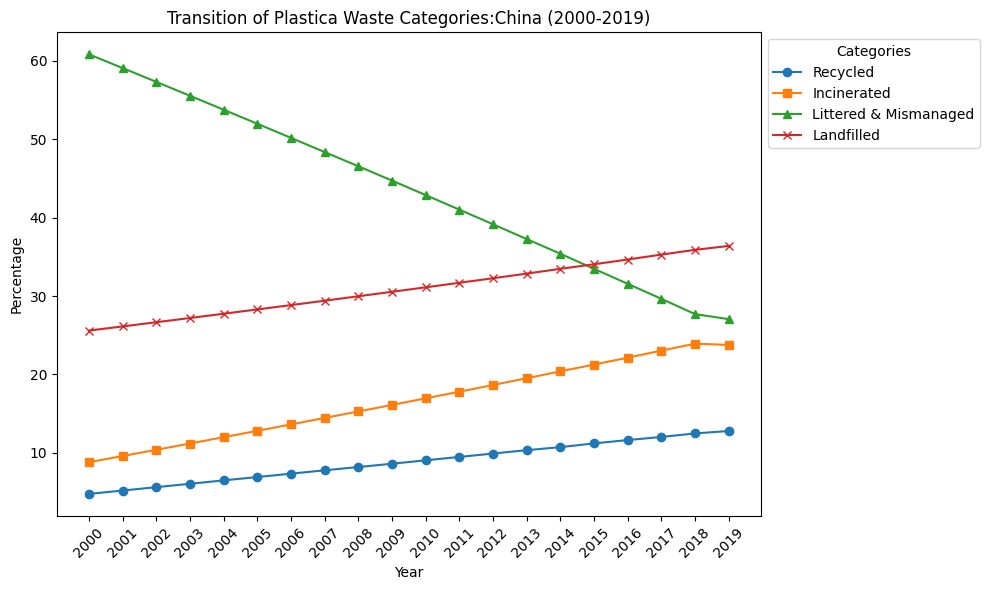

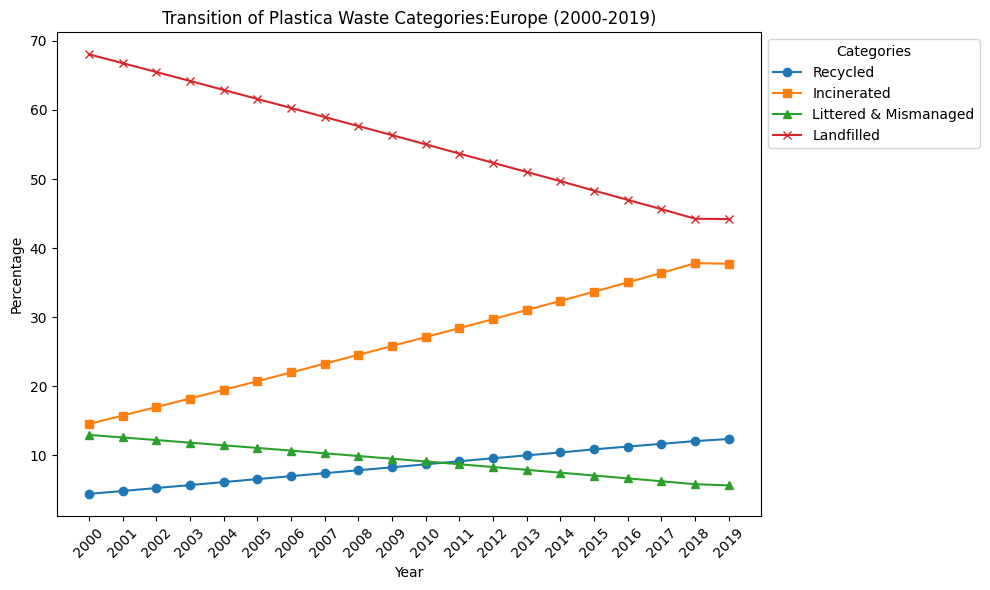

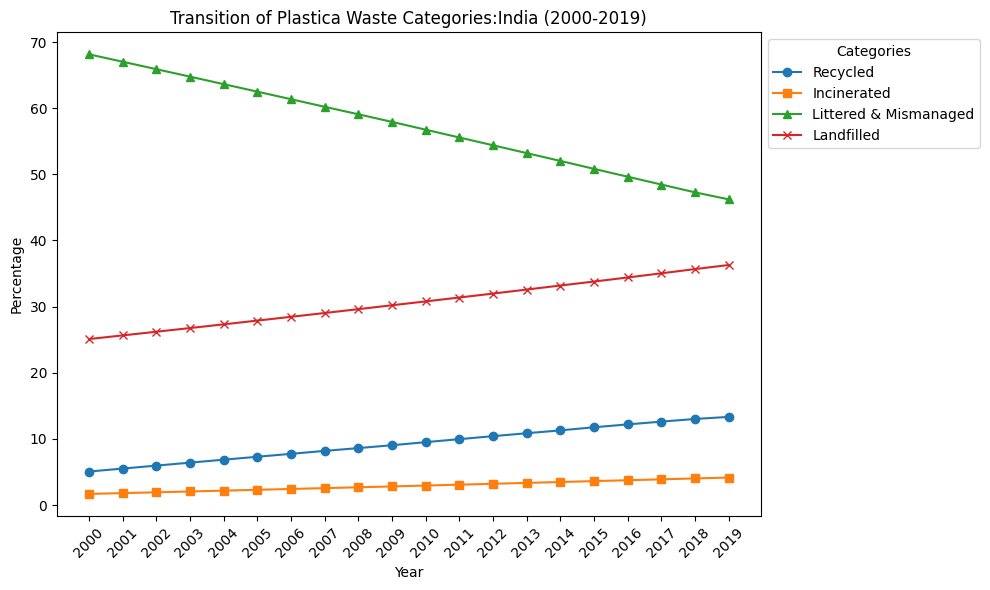

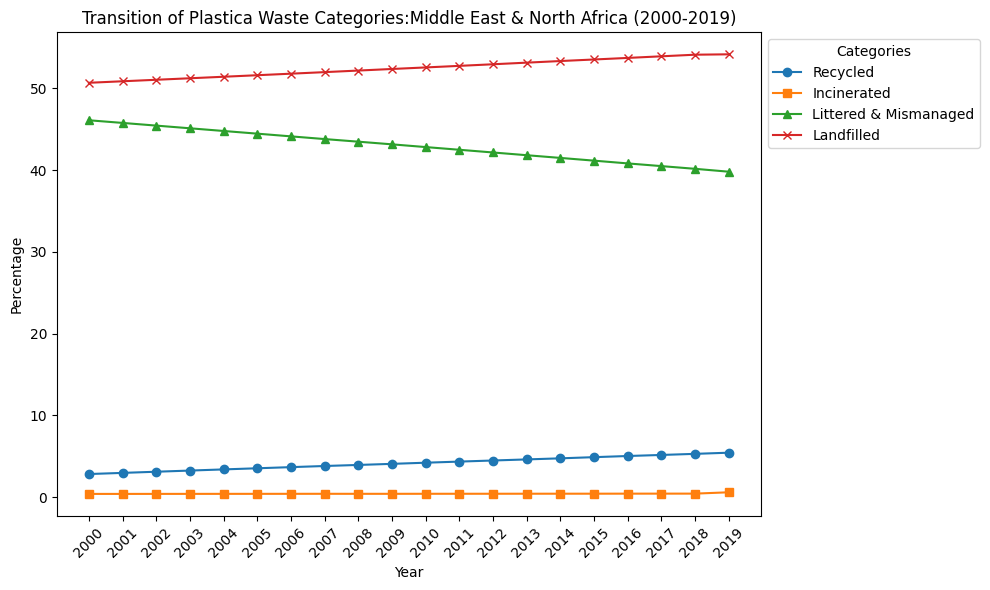

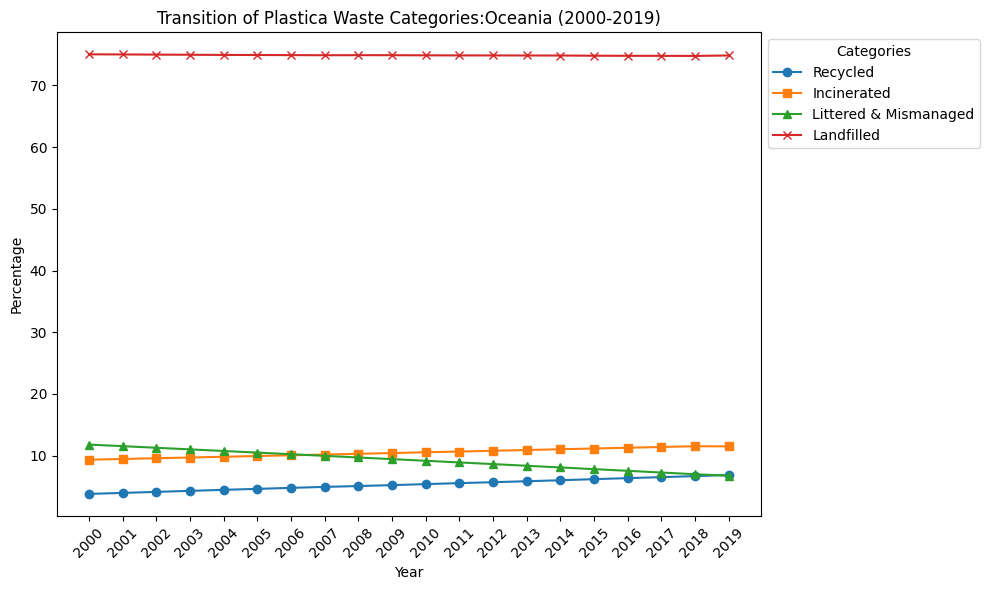

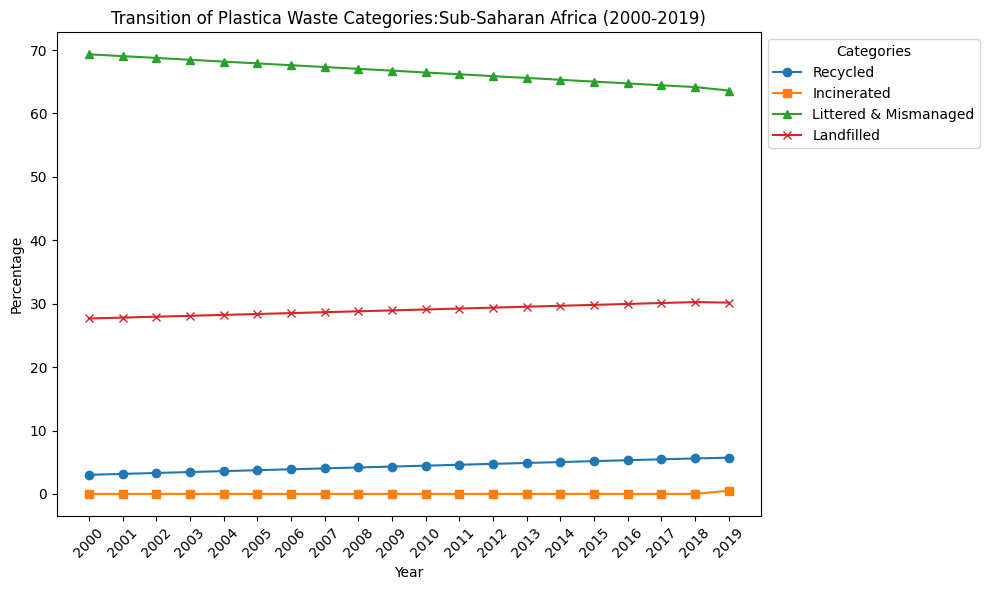

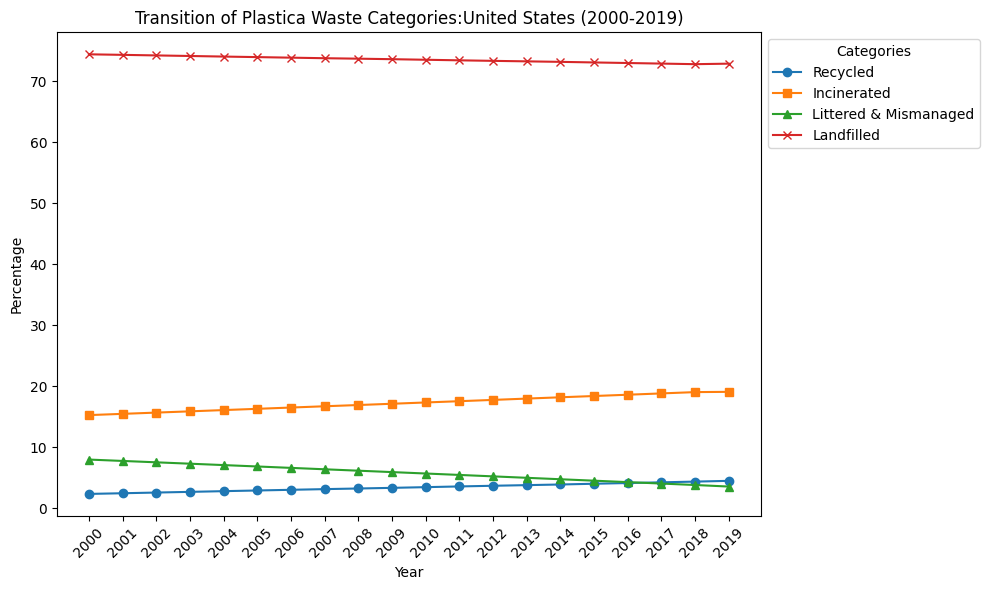

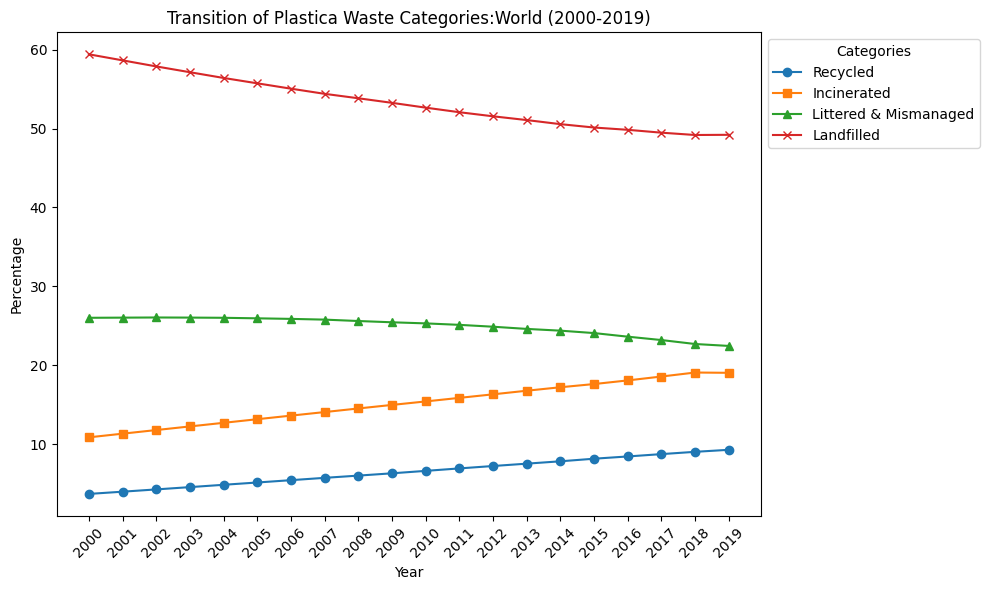

In [3]:
#Plastic management data in line graphs by continent
df3list  = df3['Entity'].unique()
Entity = df3list.tolist()

for e in Entity:
   
    df3['Year'] = df3['Year'].astype(str)
    df3_w = df3[df3['Entity'] == e ]

    plt.figure(figsize=(10, 6))
    plt.plot(df3_w['Year'], df3_w['Share of waste recycled from total regional waste'], label='Recycled', marker='o')
    plt.plot(df3_w['Year'], df3_w['Share of waste incinerated from total regional waste'], label='Incinerated', marker='s')
    plt.plot(df3_w['Year'], df3_w['Share of littered and mismanaged from total regional waste'], label='Littered & Mismanaged', marker='^')
    plt.plot(df3_w['Year'], df3_w['Share of waste landfilled from total regional waste'], label='Landfilled', marker='x')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.title(f"Transition of Plastica Waste Categories:{e} (2000-2019)")
    plt.legend(title="Categories", bbox_to_anchor=(1, 1), loc='upper left')
    plt.grid(False)
    plt.xticks(rotation=45)
    plt.tight_layout()


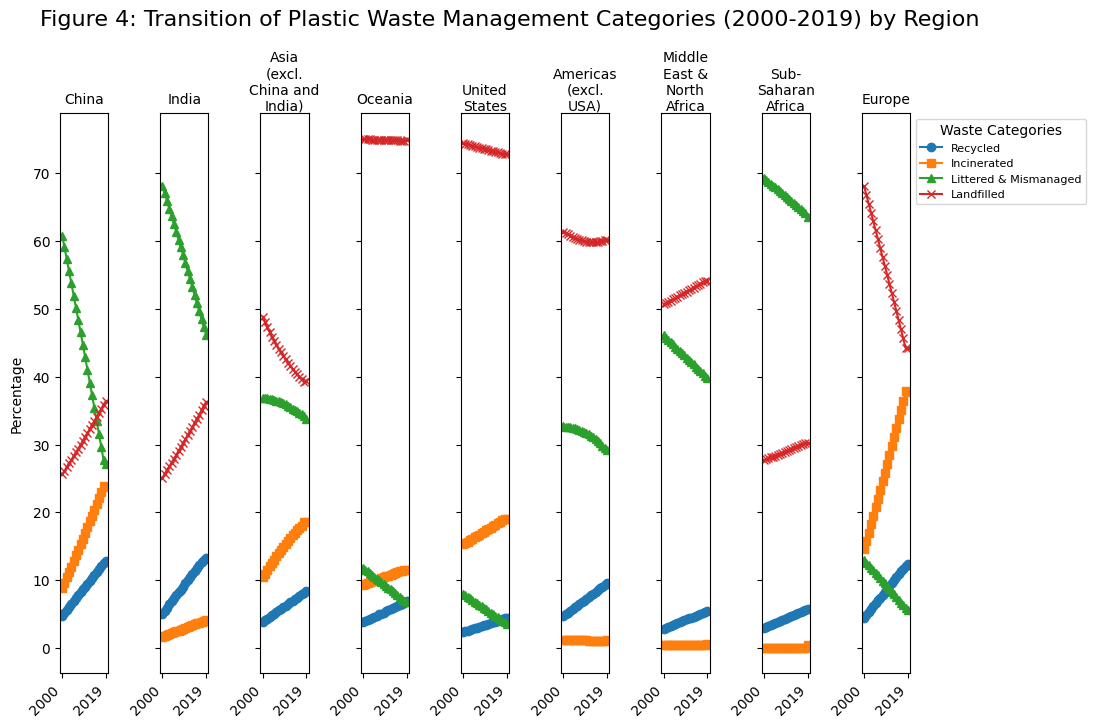

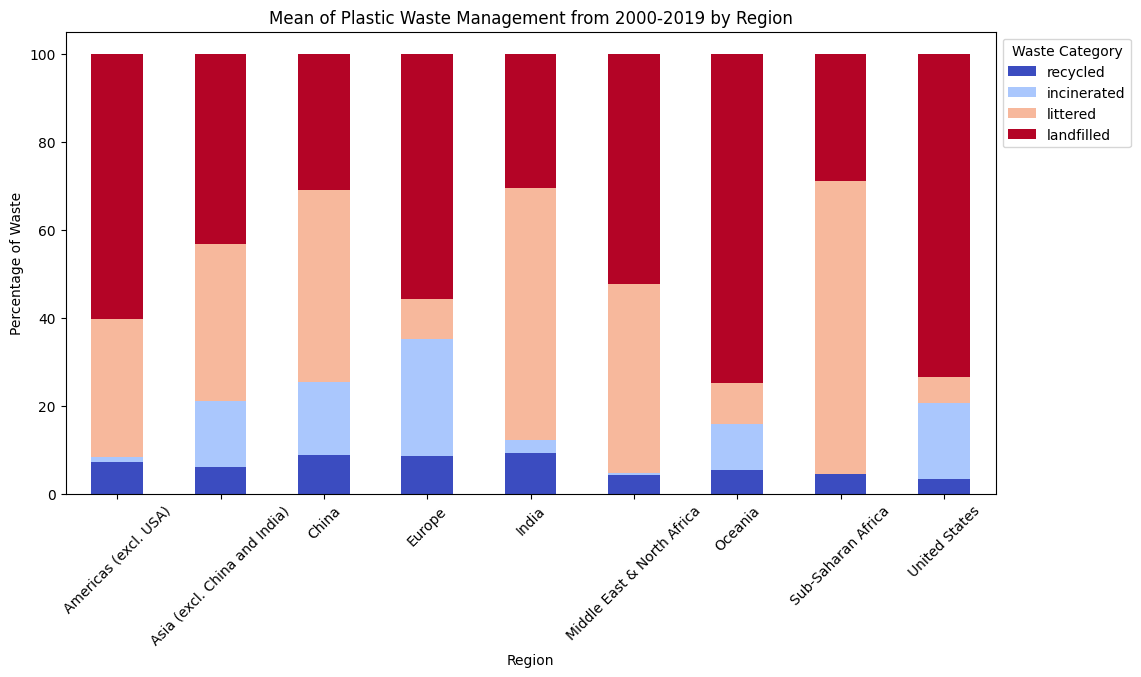

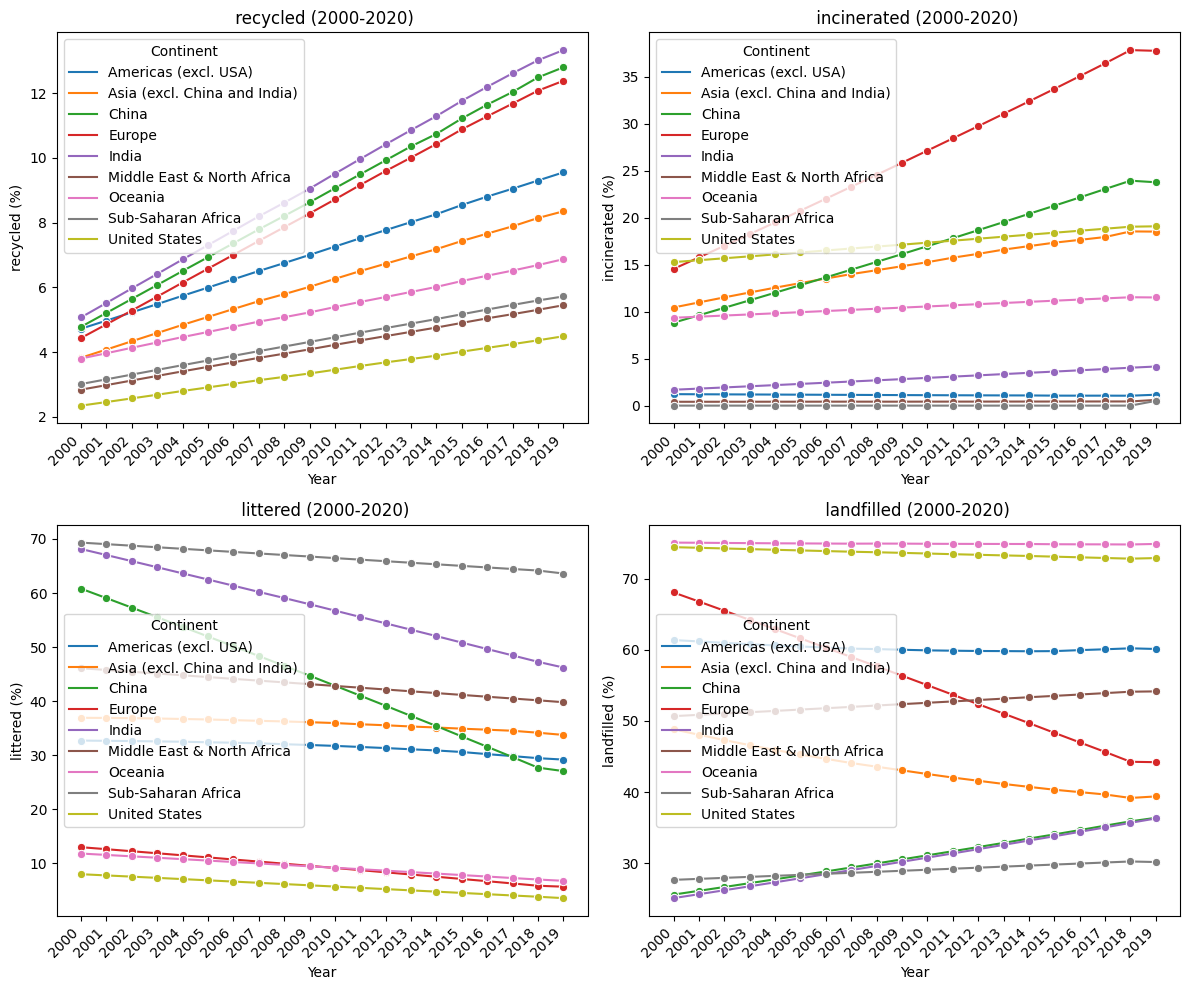

In [4]:
#Visualising the transition of plastic management to compare scores between continents
waste_categories = ['recycled', 'incinerated', 'littered', 'landfilled']

fig, axes = plt.subplots(1,9, figsize=(10, 8), sharey=True)
years = np.arange(2000, 2020)

for i, region in enumerate(country_groups):
   
    df_region = df3[df3['Entity'] == region]
    recycled = df_region['Share of waste recycled from total regional waste'].values
    incinerated = df_region['Share of waste incinerated from total regional waste'].values
    littered = df_region['Share of littered and mismanaged from total regional waste'].values
    landfilled = df_region['Share of waste landfilled from total regional waste'].values
    
   
    axes[i].plot(years, recycled, label='Recycled', marker='o')
    axes[i].plot(years, incinerated, label='Incinerated', marker='s')
    axes[i].plot(years, littered, label='Littered & Mismanaged', marker='^')
    axes[i].plot(years, landfilled, label='Landfilled', marker='x')
    
    title = f'{region}'
    wrapped_title = textwrap.fill(title, width=10)  # Set width for wrapping
    axes[i].set_title(wrapped_title, fontsize=10, pad=10, rotation=0, verticalalignment='center', horizontalalignment='center')
    
    axes[i].grid(False)
    plt.tight_layout()
    
    axes[i].set_xticks([2000, 2019])
    axes[i].set_xticklabels([2000, 2019], rotation=45, ha='right')



fig.suptitle('Figure 4: Transition of Plastic Waste Management Categories (2000-2019) by Region', fontsize=16)

fig.text(0, 0.5, 'Percentage', va='center', rotation='vertical', fontsize=10)

axes[i].legend(title="Waste Categories", bbox_to_anchor=(1, 1), loc='upper left',fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 1])  
fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.9)


region_summary = merged_df.groupby("continent")[["recycled", "incinerated", "littered", "landfilled"]].mean().reset_index()

#Bargraph
region_summary.set_index("continent").plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12, 6))
plt.title("Mean of Plastic Waste Management from 2000-2019 by Region")
plt.ylabel("Percentage of Waste")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.legend(title="Waste Category", bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

def compute_medians_by_continent_year(merged_df, waste_categories):
    median_results = merged_df.groupby(["continent", "year"])[waste_categories + ["goal_4_score", "goal_8_score"]].median().reset_index()
    return median_results

median_df_yearly = compute_medians_by_continent_year(merged_df, waste_categories)

median_df_yearly["year"] = median_df_yearly["year"].astype(str)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, category in enumerate(waste_categories):
    sns.lineplot(data=median_df_yearly, x="year", y=category, hue="continent", marker="o", ax=axes[i])
    axes[i].set_title(f" {category} (2000-2020)", fontsize=12)
    axes[i].set_xlabel("Year", fontsize=10)
    axes[i].set_ylabel(f"{category} (%)", fontsize=10)
    axes[i].grid(False)
    axes[i].legend(title="Continent")
    
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")  

plt.tight_layout()


Median Scores Per Continent Over Time:
     year                     continent  goal_4_score  goal_8_score
0    2000          Americas (excl. USA)         79.75         68.75
1    2000  Asia (excl. China and India)         89.70         72.90
2    2000                         China         98.00         75.10
3    2000                        Europe         94.80         78.90
4    2000                         India         60.60         66.40
..    ...                           ...           ...           ...
225  2022    Middle East & North Africa         80.80         68.30
226  2022                       Oceania         91.60         81.80
227  2022                        Others         79.50         71.10
228  2022            Sub-Saharan Africa         50.70         66.60
229  2022                 United States         93.90         81.90

[230 rows x 4 columns]
Spearman Correlation Per Continent:
                      continent  spearman_r   p_value
0          Americas (excl. USA)

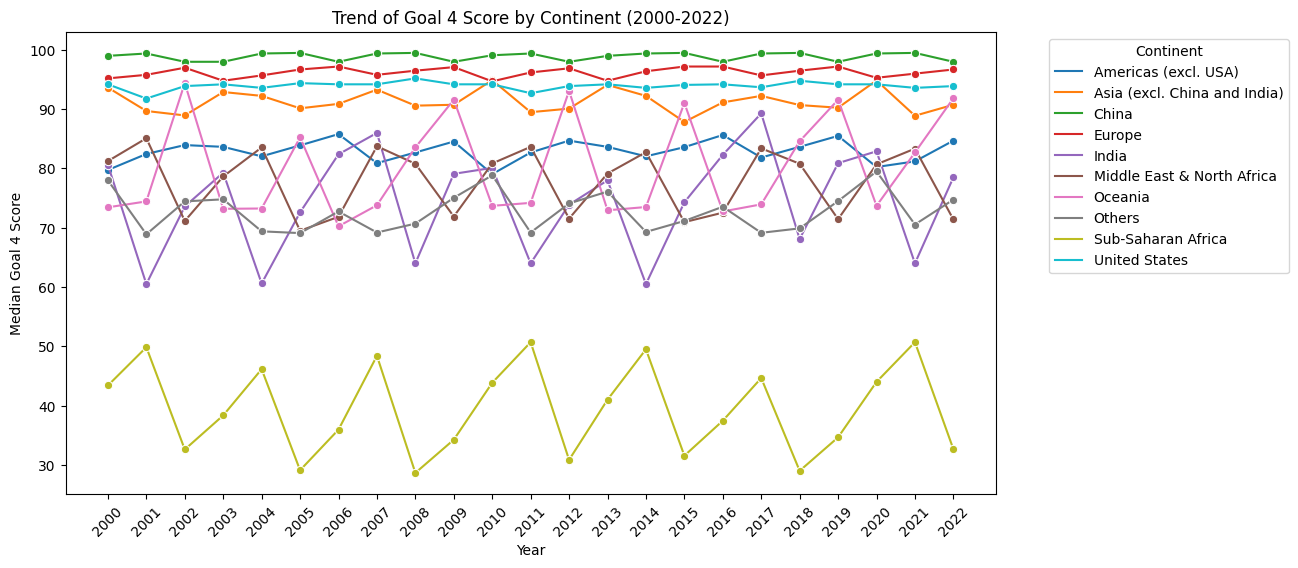

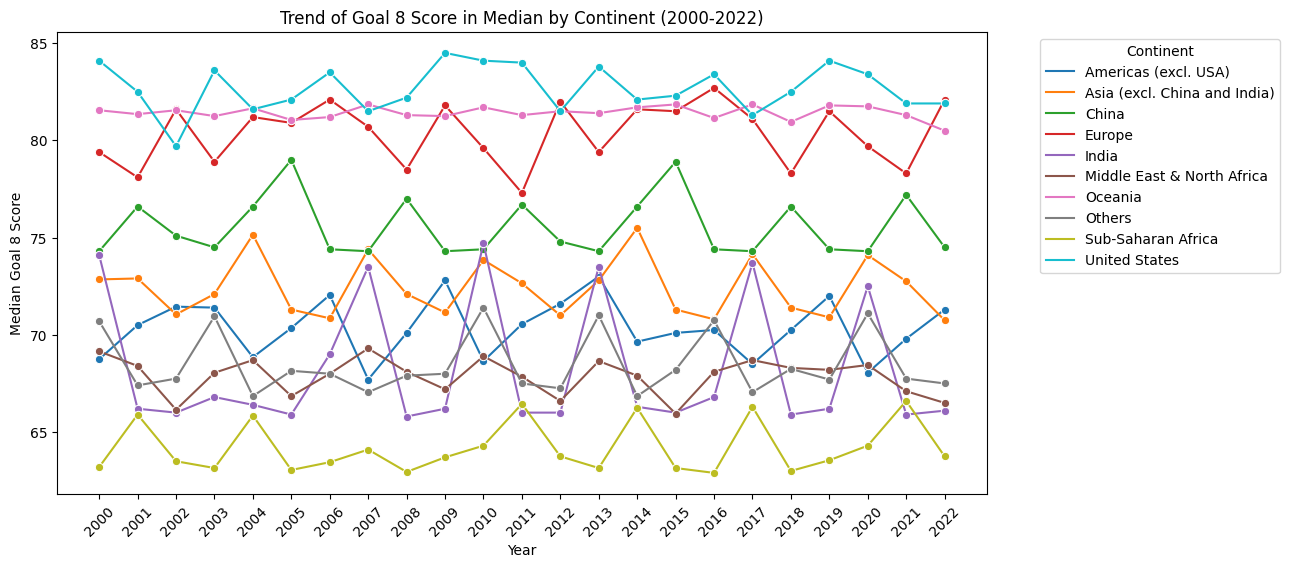

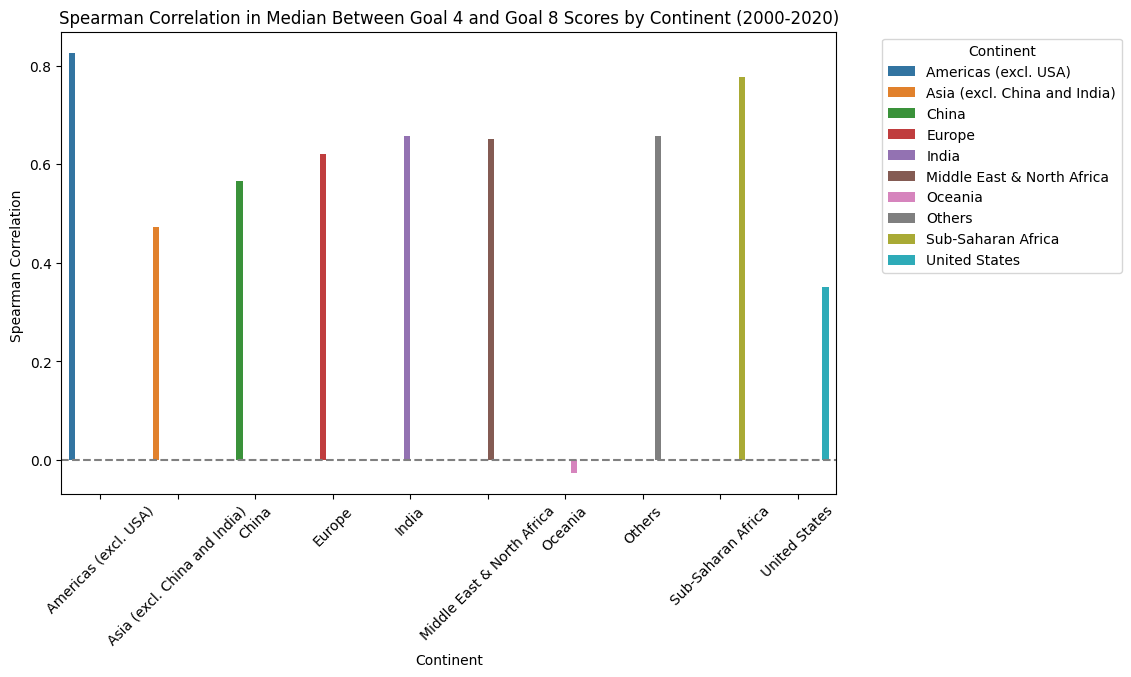

In [5]:
#Trend of respective Goal 4 and Goal 8 Score by Continent (2000-2022) and their Spearman correlation in median
# MEDIAN
median_scores = df_sdg.groupby(["year", "continent"])[["goal_4_score", "goal_8_score"]].median().reset_index()

# Pearson correlation per continent : goal4 and goal 8
correlation_results = []
for continent in median_scores["continent"].unique():
    df_continent = median_scores[median_scores["continent"] == continent]
    if len(df_continent) > 1:
        r, p_value = spearmanr(df_continent["goal_4_score"], df_continent["goal_8_score"])
        correlation_results.append({"continent": continent, "spearman_r": r, "p_value": p_value})

spearman48correlation_df = pd.DataFrame(correlation_results) 

df_sdg["year"] = df_sdg["year"].astype(str).str.replace(".0", "", regex=False).astype(str)

# GOAL4
plt.figure(figsize=(12, 6))
sns.lineplot(data=median_scores, x=df_sdg["year"], y="goal_4_score", hue="continent", marker="o")
plt.xlabel("Year")
plt.ylabel("Median Goal 4 Score")
plt.title("Trend of Goal 4 Score by Continent (2000-2022)")
plt.legend(title="Continent", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.xticks(rotation=45)

#GOAL8
plt.figure(figsize=(12, 6))
sns.lineplot(data=median_scores, x=df_sdg["year"], y="goal_8_score", hue="continent", marker="o")
plt.xlabel("Year")
plt.ylabel("Median Goal 8 Score")
plt.title("Trend of Goal 8 Score in Median by Continent (2000-2022)")
plt.legend(title="Continent",bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.xticks(rotation=45)


print("Median Scores Per Continent Over Time:")
print(median_scores)


# spearman correlation : goal 4 and goal 8
plt.figure(figsize=(10, 6))
sns.barplot(data=spearman48correlation_df, x="continent", y="spearman_r", hue="continent")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Continent")
plt.ylabel("Spearman Correlation ")
plt.title("Spearman Correlation in Median Between Goal 4 and Goal 8 Scores by Continent (2000-2020)")
plt.grid(False)
plt.xticks(rotation=45)
plt.legend(title="Continent",bbox_to_anchor=(1.05, 1), loc='upper left')


print("Spearman Correlation Per Continent:")
print(spearman48correlation_df)


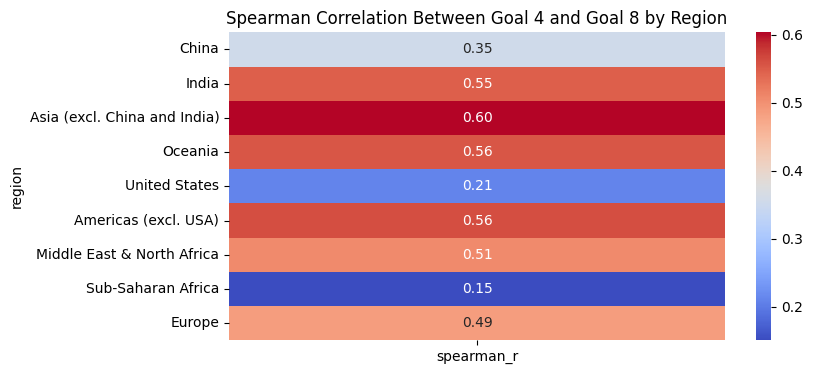

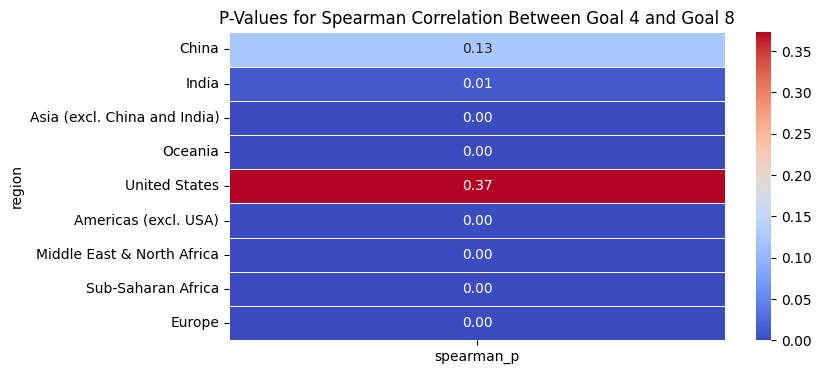

Spearman Correlation Results(without plastic categories):
                         region  spearman_r    spearman_p
0                         China    0.354379  1.252668e-01
1                         India    0.547049  1.255212e-02
2  Asia (excl. China and India)    0.603655  3.746195e-33
3                       Oceania    0.555355  8.961524e-08
4                 United States    0.210593  3.728144e-01
5          Americas (excl. USA)    0.562833  8.779470e-45
6    Middle East & North Africa    0.506555  1.851307e-27
7            Sub-Saharan Africa    0.150473  3.525860e-04
8                        Europe    0.485379  5.825936e-38
Spearman Correlation Results:
    region          goal plastic_category  spearman_r    spearman_p
0    China  goal_4_score         recycled    0.945110  3.516909e-10
1    China  goal_8_score         recycled    0.424599  6.203896e-02
2    China  goal_4_score      incinerated    0.945110  3.516909e-10
3    China  goal_8_score      incinerated    0.426132  6.100

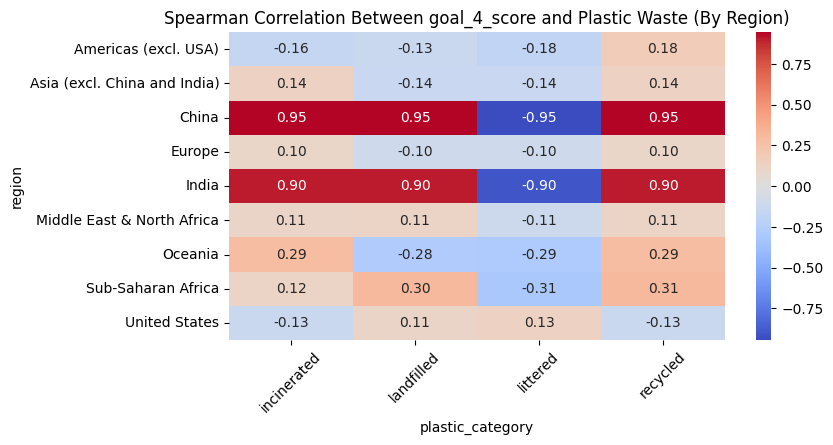

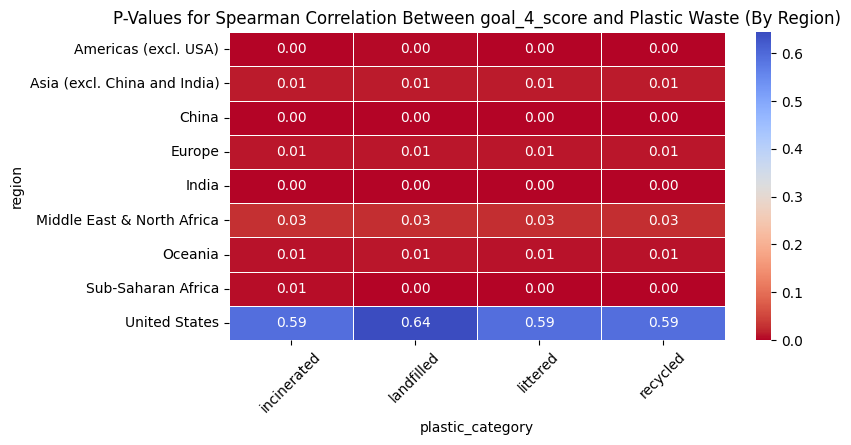

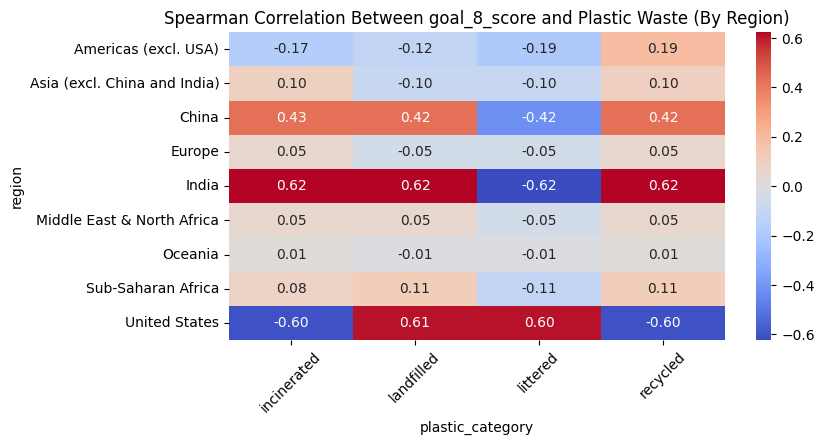

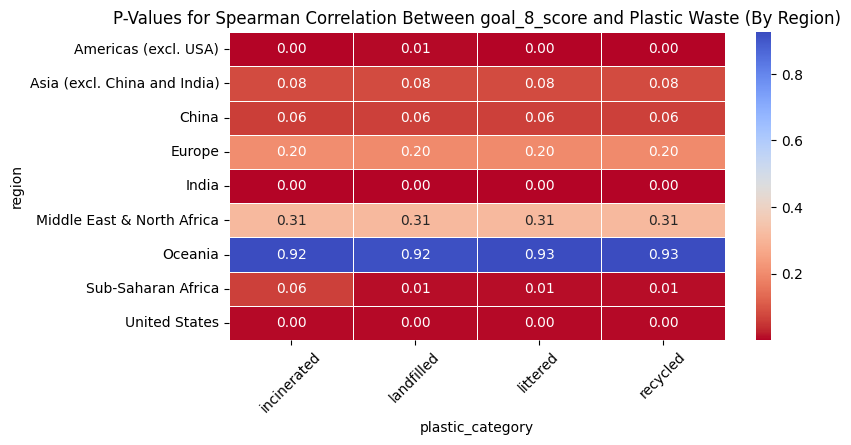

In [6]:

#Spearman correlation of goal 4 and goal 8 with p value(not median) 
correlation_results = []

goal_correlation_results = []

for region in country_groups:
    df_region = merged_df[merged_df["continent"] == region]
    if len(df_region) > 1:
        spearman_corr, spearman_p = spearmanr(df_region["goal_4_score"], df_region["goal_8_score"])
        
        goal_correlation_results.append({
            "region": region,
            "spearman_r": spearman_corr,
            "spearman_p": spearman_p
        })

spearman48 = pd.DataFrame(goal_correlation_results)

for region in country_groups:
    df_region = merged_df[merged_df["continent"] == region]
    if len(df_region) > 1:
        for category in waste_categories:
            for goal in ["goal_4_score", "goal_8_score"]:
                spearman_corr, spearman_p = spearmanr(df_region[goal], df_region[category])
                
                correlation_results.append({
                    "region": region,
                    "goal": goal,
                    "plastic_category": category,
                    "spearman_r": spearman_corr,
                    "spearman_p": spearman_p
                })


spearman48_all = pd.DataFrame(correlation_results)

plt.figure(figsize=(8, 4))
sns.heatmap(spearman48.set_index("region")[["spearman_r"]], 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Between Goal 4 and Goal 8 by Region")
plt.show()


plt.figure(figsize=(8, 4))
sns.heatmap(spearman48.set_index("region")[["spearman_p"]], 
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("P-Values for Spearman Correlation Between Goal 4 and Goal 8")
plt.show()

#Spearman correlation of goal 4 & plastic management and goal 8 & plastic managemen 
for goal in ["goal_4_score", "goal_8_score"]:
    plt.figure(figsize=(8, 4))

    pivot_r = spearman48_all[spearman48_all["goal"] == goal].pivot(index="region", columns="plastic_category", values="spearman_r")
    sns.heatmap(pivot_r, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Spearman Correlation Between {goal} and Plastic Waste (By Region)")
    plt.xticks(rotation=45)
    
    plt.figure(figsize=(8, 4))
    pivot_p = spearman48_all[spearman48_all["goal"] == goal].pivot(index="region", columns="plastic_category", values="spearman_p")
    sns.heatmap(pivot_p, annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)
    plt.title(f"P-Values for Spearman Correlation Between {goal} and Plastic Waste (By Region)")
    plt.xticks(rotation=45)
    

    
print("Spearman Correlation Results(without plastic categories):")
print(spearman48)

print("Spearman Correlation Results:")
print(spearman48_all)

print(f'No Spearman p value is 0')

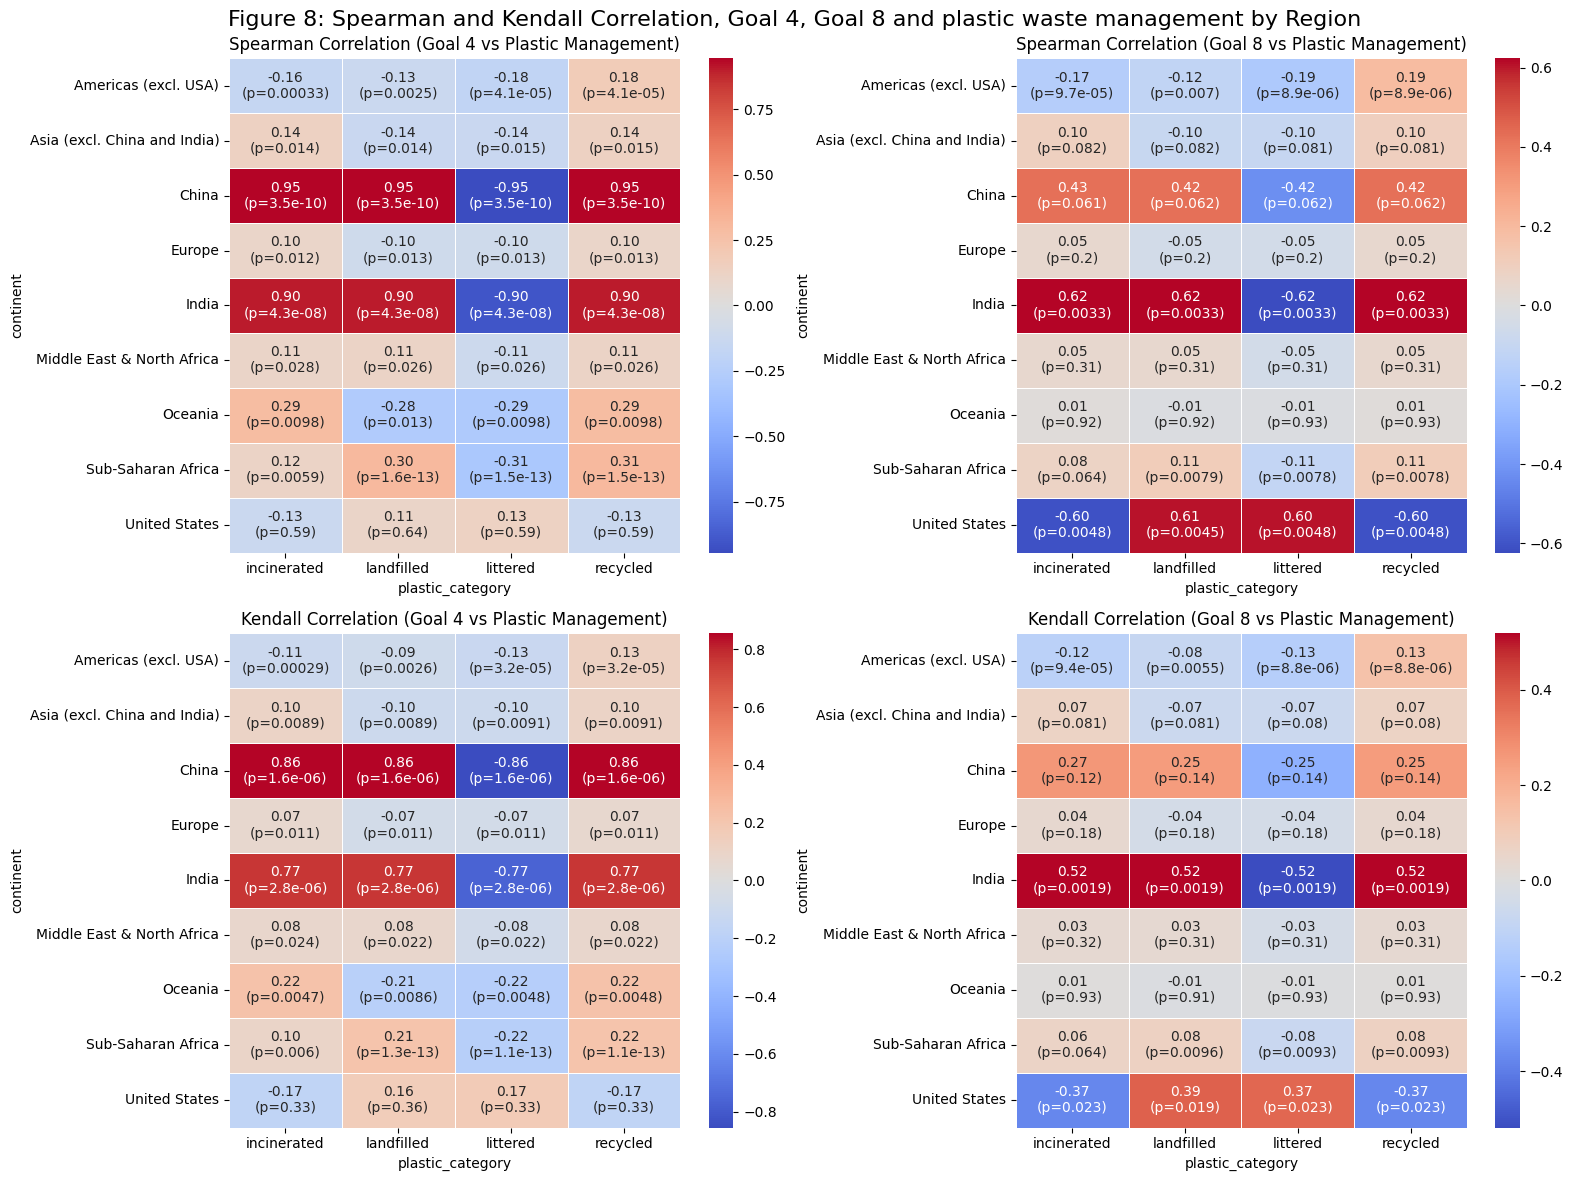

In [19]:

def compute_correlations_by_continent(df, goal, waste_categories):
    correlation_results = []
    
    for continent, sub_df in df.groupby("continent"): 
        for category in waste_categories:
            spearman_corr, spearman_p = spearmanr(sub_df[goal], sub_df[category], nan_policy="omit")
            kendall_corr, kendall_p = kendalltau(sub_df[goal], sub_df[category], nan_policy="omit")
            
            correlation_results.append({
                "continent": continent,
                "goal": goal,  
                "plastic_category": category,
                "spearman_r": spearman_corr,
                "spearman_p": spearman_p,
                "kendall_tau": kendall_corr,
                "kendall_p": kendall_p
            })
    
    return pd.DataFrame(correlation_results)


# Compute correlations for Goal 4 & Goal 8
corr_goal_4 = compute_correlations_by_continent(merged_df, "goal_4_score", waste_categories)
corr_goal_8 = compute_correlations_by_continent(merged_df, "goal_8_score", waste_categories)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Function to format correlation & p-value in the heatmap
def format_value(corr, p_val):
    if np.isnan(corr):
        return "NaN"
    return f"{corr:.2f}\n(p={p_val:.2g})"

# Apply formatting
corr_goal_4["spearman_text"] = corr_goal_4.apply(lambda row: format_value(row["spearman_r"], row["spearman_p"]), axis=1)
corr_goal_8["spearman_text"] = corr_goal_8.apply(lambda row: format_value(row["spearman_r"], row["spearman_p"]), axis=1)
corr_goal_4["kendall_text"] = corr_goal_4.apply(lambda row: format_value(row["kendall_tau"], row["kendall_p"]), axis=1)
corr_goal_8["kendall_text"] = corr_goal_8.apply(lambda row: format_value(row["kendall_tau"], row["kendall_p"]), axis=1)

# Heatmaps with correlation & p-values


fig.suptitle('Figure 8: Spearman and Kendall Correlation, Goal 4, Goal 8 and plastic waste management by Region', fontsize=16)
sns.heatmap(
    corr_goal_4.pivot(index="continent", columns="plastic_category", values="spearman_r"),
    annot=corr_goal_4.pivot(index="continent", columns="plastic_category", values="spearman_text"),
    cmap="coolwarm", fmt="", linewidths=0.5, ax=axes[0, 0]
)
axes[0, 0].set_title("Spearman Correlation (Goal 4 vs Plastic Management)")

sns.heatmap(
    corr_goal_8.pivot(index="continent", columns="plastic_category", values="spearman_r"),
    annot=corr_goal_8.pivot(index="continent", columns="plastic_category", values="spearman_text"),
    cmap="coolwarm", fmt="", linewidths=0.5, ax=axes[0, 1]
)
axes[0, 1].set_title("Spearman Correlation (Goal 8 vs Plastic Management)")

sns.heatmap(
    corr_goal_4.pivot(index="continent", columns="plastic_category", values="kendall_tau"),
    annot=corr_goal_4.pivot(index="continent", columns="plastic_category", values="kendall_text"),
    cmap="coolwarm", fmt="", linewidths=0.5, ax=axes[1, 0]
)
axes[1, 0].set_title("Kendall Correlation (Goal 4 vs Plastic Management)")

sns.heatmap(
    corr_goal_8.pivot(index="continent", columns="plastic_category", values="kendall_tau"),
    annot=corr_goal_8.pivot(index="continent", columns="plastic_category", values="kendall_text"),
    cmap="coolwarm", fmt="", linewidths=0.5, ax=axes[1, 1]
)
axes[1, 1].set_title("Kendall Correlation (Goal 8 vs Plastic Management)")

plt.tight_layout()
plt.show()


Spearman & Kendall Correlation Results:
           goal plastic_category  spearman_r     spearman_p  kendall_tau  \
0  goal_4_score         recycled    0.496717  1.326108e-159     0.348278   
1  goal_4_score      incinerated    0.694148   0.000000e+00     0.511354   
2  goal_4_score         littered   -0.655890  9.077803e-315    -0.476682   
3  goal_4_score       landfilled    0.412293  1.237845e-105     0.274435   
0  goal_8_score         recycled    0.391316   1.920700e-94     0.269109   
1  goal_8_score      incinerated    0.570523  5.153986e-221     0.402379   
2  goal_8_score         littered   -0.574173  1.809369e-224    -0.404178   
3  goal_8_score       landfilled    0.345786   8.395425e-73     0.234309   

       kendall_p  
0  5.765172e-152  
1   0.000000e+00  
2  7.496811e-283  
3   4.190708e-95  
0   1.724411e-91  
1  1.474303e-195  
2  7.101843e-204  
3   8.184255e-70  
Spearman & Kendall Correlation by Region:
                          region plastic_category  spearman_r 

/tmp/ipykernel_255/578522031.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(correlation_df.pivot("goal", "plastic_category", "spearman_r"), annot=True, cmap="coolwarm", fmt=".2f")
/tmp/ipykernel_255/578522031.py:35: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(correlation_df.pivot("goal", "plastic_category", "kendall_tau"), annot=True, cmap="coolwarm", fmt=".2f")


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'incinerated'),
  Text(1.5, 0, 'landfilled'),
  Text(2.5, 0, 'littered'),
  Text(3.5, 0, 'recycled')])

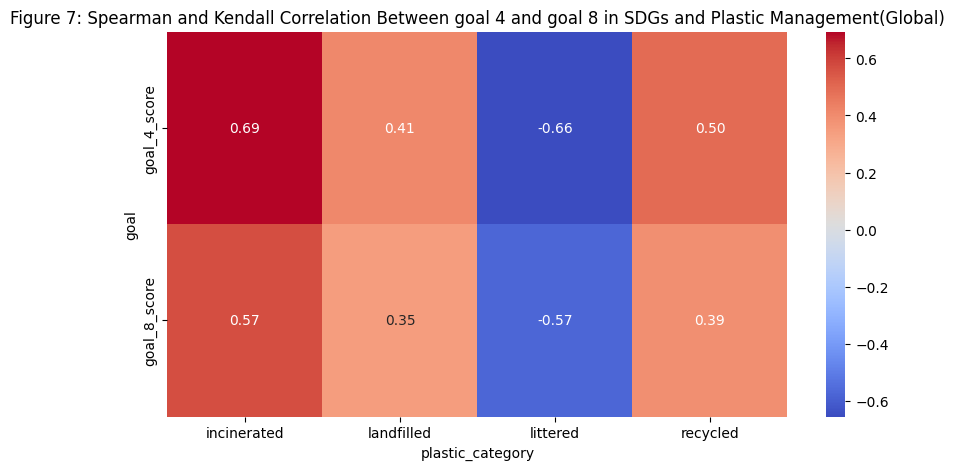

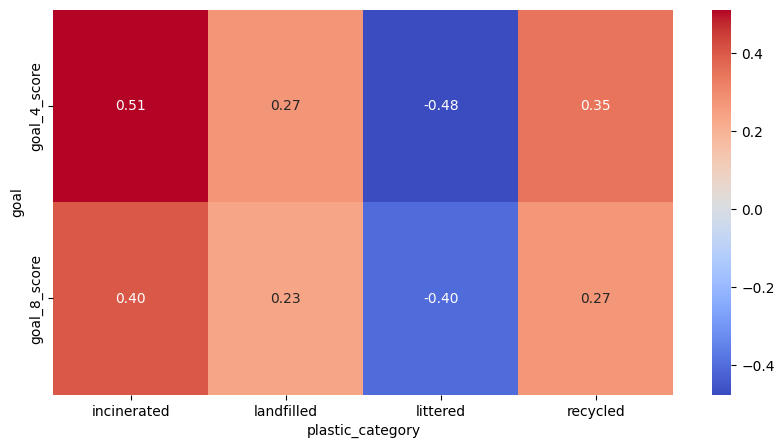

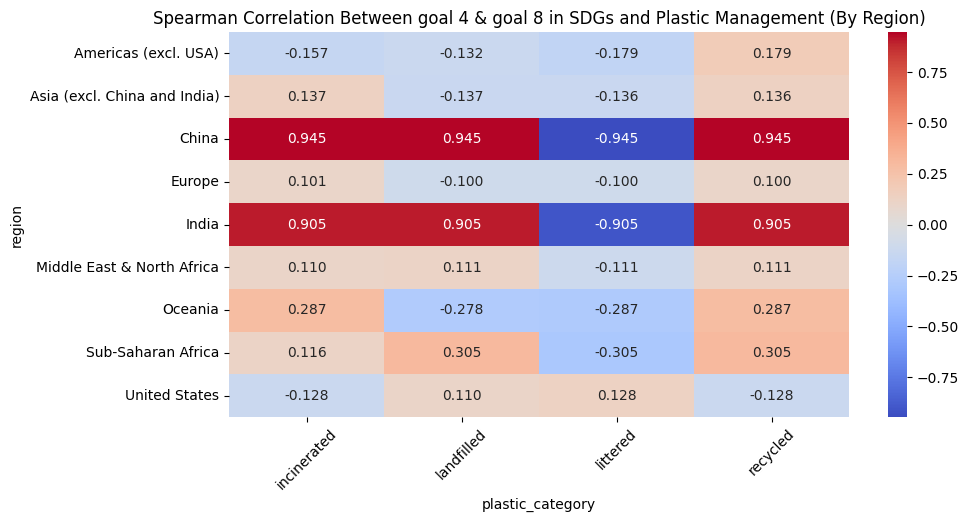

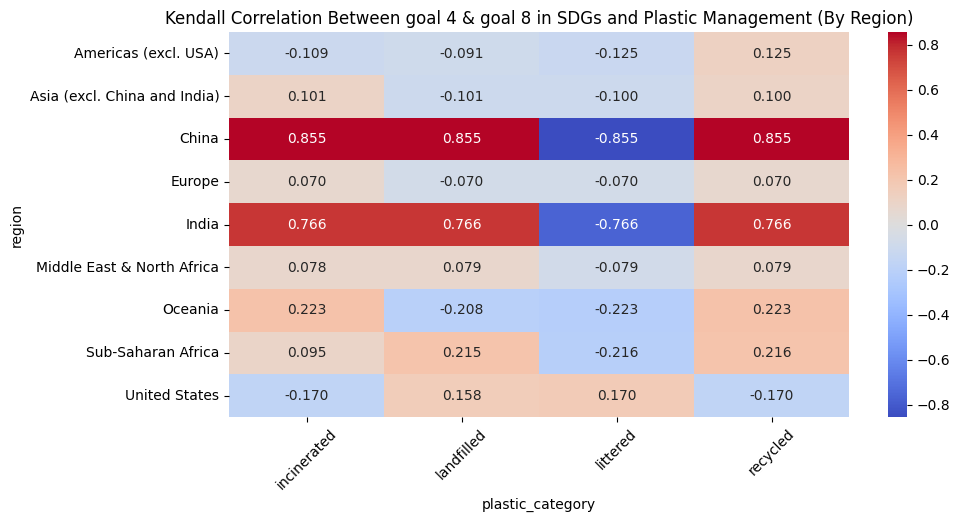

In [17]:
#Global correlation between goal 4 , goal 8 and plastic management by category with Spearman and kendall
def compute_correlations(df, goal, waste_categories):
    correlation_results = []
    for category in waste_categories:
        spearman_corr, spearman_p = spearmanr(merged_df[goal], merged_df[category])
        kendall_corr, kendall_p = kendalltau(merged_df[goal], merged_df[category])
        correlation_results.append({
            "goal": goal,
            "plastic_category": category,
            "spearman_r": spearman_corr,
            "spearman_p": spearman_p,
            "kendall_tau": kendall_corr,
            "kendall_p": kendall_p
            
        })
    return pd.DataFrame(correlation_results)



corr_goal_4 = compute_correlations(merged_df, "goal_4_score", waste_categories)
corr_goal_8 = compute_correlations(merged_df, "goal_8_score", waste_categories)

correlation_df = pd.concat([corr_goal_4, corr_goal_8])

print("Spearman & Kendall Correlation Results:")
print(correlation_df)

 
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df.pivot("goal", "plastic_category", "spearman_r"), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Between goal 4 and goal 8 in SDGs and Plastic Management(Global)")


plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df.pivot("goal", "plastic_category", "kendall_tau"), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Kendall Correlation Between goal 4 and goal 8 in SDGs and Plastic Management(Global)")




correlation_results = []
for region in country_groups:
    df_region = merged_df[merged_df["continent"] == region]
    if len(df_region) > 1:  
        for category in waste_categories:
            spearman_corr, spearman_p = spearmanr(df_region["goal_4_score"], df_region[category])
            kendall_corr, kendall_p = kendalltau(df_region["goal_4_score"], df_region[category])
            correlation_results.append({
                "region": region,
                "plastic_category": category,
                "spearman_r": spearman_corr,
                "spearman_p": spearman_p,
                "kendall_tau": kendall_corr,
                "kendall_p": kendall_p
            })
    else:
        for category in waste_categories:
            correlation_results.append({
                "region": region,
                "plastic_category": category,
                "spearman_r": np.nan,
                "spearman_p": np.nan,
                "kendall_tau": np.nan,
                "kendall_p": np.nan
            })

correlation_df = pd.DataFrame(correlation_results)

print("Spearman & Kendall Correlation by Region:")
print(correlation_df)

# Heatmap 
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df.pivot(index="region", columns="plastic_category", values="spearman_r"), 
            annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Spearman Correlation Between goal 4 & goal 8 in SDGs and Plastic Management (By Region)")
plt.xticks(rotation=45)
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df.pivot(index="region", columns="plastic_category", values="kendall_tau"), 
            annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Kendall Correlation Between goal 4 & goal 8 in SDGs and Plastic Management (By Region)")
plt.xticks(rotation=45)


  plastic_category  goal_4_spearman_r  goal_4_p_value  goal_8_spearman_r  \
0         recycled           0.496717   1.326108e-159           0.391316   
1      incinerated           0.694148    0.000000e+00           0.570523   
2         littered          -0.655890   9.077803e-315          -0.574173   
3       landfilled           0.412293   1.237845e-105           0.345786   

   goal_8_p_value  fisher_z  
0    1.920700e-94  4.705013  
1   5.153986e-221  7.423683  
2   1.809369e-224 -4.714072  
3    8.395425e-73  2.779010  


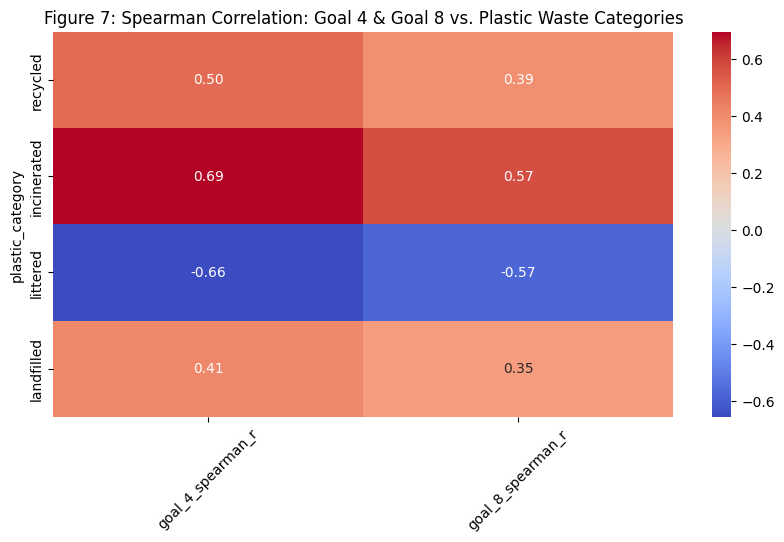

                       continent plastic_category  goal_4_spearman_r  \
0                         Europe         recycled           0.100253   
1                         Europe      incinerated           0.100537   
2                         Europe         littered          -0.100253   
3                         Europe       landfilled          -0.100253   
4     Middle East & North Africa         recycled           0.111374   
5     Middle East & North Africa      incinerated           0.109917   
6     Middle East & North Africa         littered          -0.111374   
7     Middle East & North Africa       landfilled           0.111374   
8             Sub-Saharan Africa         recycled           0.305357   
9             Sub-Saharan Africa      incinerated           0.116124   
10            Sub-Saharan Africa         littered          -0.305357   
11            Sub-Saharan Africa       landfilled           0.304883   
12          Americas (excl. USA)         recycled           0.17

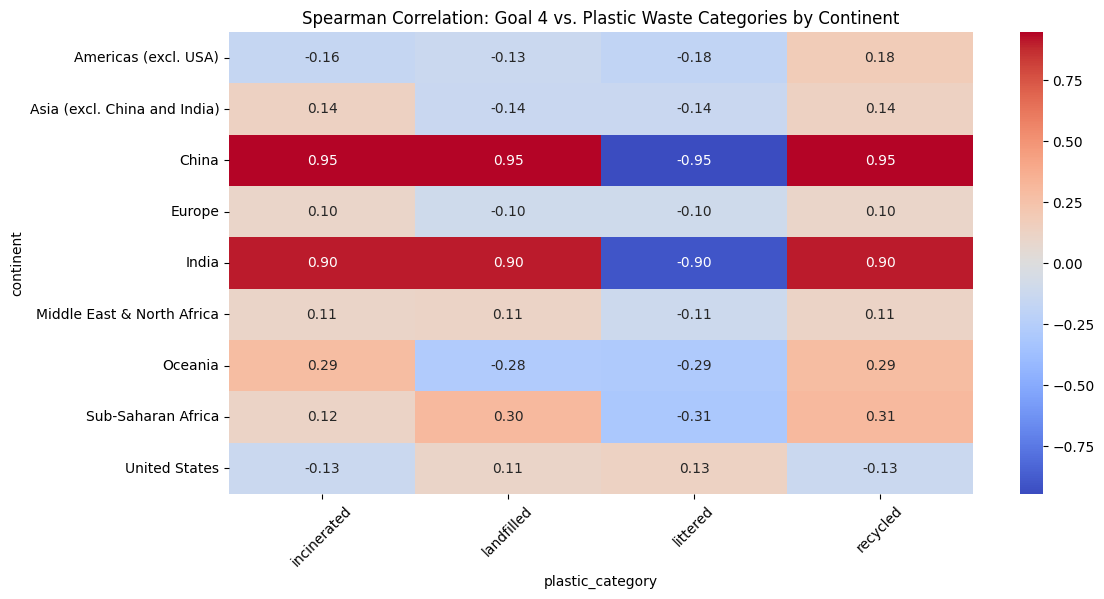

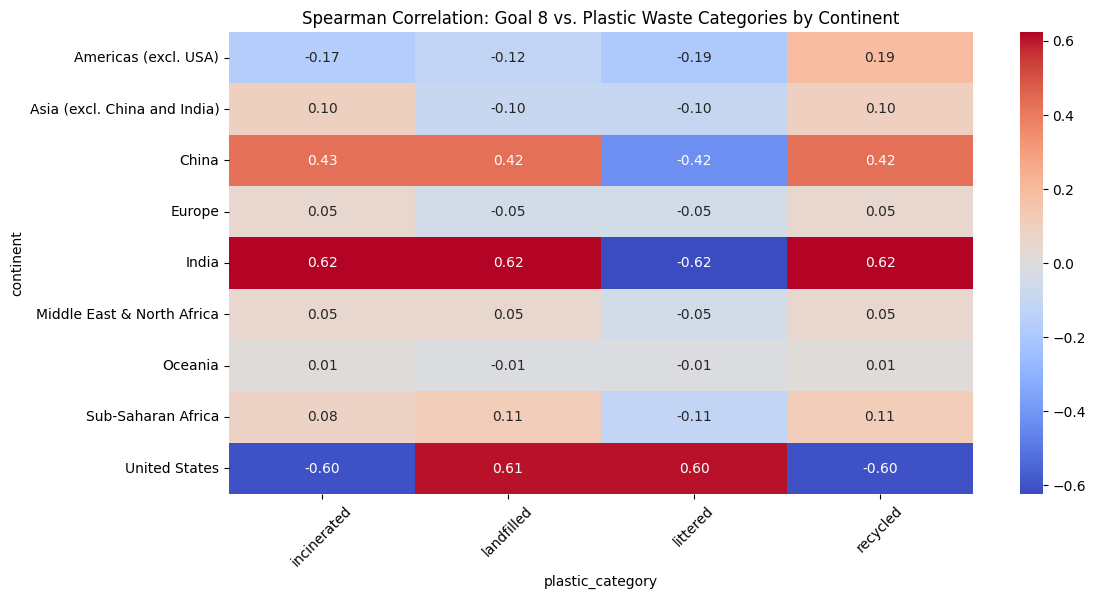


Regression results for recycled:
                            OLS Regression Results                            
Dep. Variable:               recycled   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     399.9
Date:                Fri, 14 Mar 2025   Prob (F-statistic):          7.48e-152
Time:                        10:02:43   Log-Likelihood:                -5476.4
No. Observations:                2560   AIC:                         1.096e+04
Df Residuals:                    2557   BIC:                         1.098e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         

In [18]:
 # Fisher's Z-test for correlation comparison

correlation_results = []
for category in waste_categories:
    spearman_corr_4, spearman_p_4 = spearmanr(merged_df["goal_4_score"], merged_df[category])
    spearman_corr_8, spearman_p_8 = spearmanr(merged_df["goal_8_score"], merged_df[category])
    
   
    if spearman_corr_4 is not None and spearman_corr_8 is not None:
        z_4 = np.arctanh(spearman_corr_4)
        z_8 = np.arctanh(spearman_corr_8)
        n = len(merged_df)
        se_diff = np.sqrt((1/(n-3)) + (1/(n-3)))
        fisher_z = (z_4 - z_8) / se_diff
    else:
        fisher_z = np.nan
    
    correlation_results.append({
        "plastic_category": category,
        "goal_4_spearman_r": spearman_corr_4,
        "goal_4_p_value": spearman_p_4,
        "goal_8_spearman_r": spearman_corr_8,
        "goal_8_p_value": spearman_p_8,
        "fisher_z": fisher_z
    })

correlation_df = pd.DataFrame(correlation_results)
print(correlation_df)

plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df.set_index("plastic_category")[['goal_4_spearman_r', 'goal_8_spearman_r']], 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Figure 7: Spearman Correlation: Goal 4 & Goal 8 vs. Plastic Waste Categories")
plt.xticks(rotation=45)
plt.show()


continent_results = []
for continent in merged_df["continent"].unique():
    df_continent = merged_df[merged_df["continent"] == continent]
    for category in waste_categories:
        spearman_corr_4, spearman_p_4 = spearmanr(df_continent["goal_4_score"], df_continent[category])
        spearman_corr_8, spearman_p_8 = spearmanr(df_continent["goal_8_score"], df_continent[category])
        
        continent_results.append({
            "continent": continent,
            "plastic_category": category,
            "goal_4_spearman_r": spearman_corr_4,
            "goal_4_p_value": spearman_p_4,
            "goal_8_spearman_r": spearman_corr_8,
            "goal_8_p_value": spearman_p_8
        })

continent_correlation_df = pd.DataFrame(continent_results)
print(continent_correlation_df)

plt.figure(figsize=(12, 6))
sns.heatmap(continent_correlation_df.pivot(index="continent", columns="plastic_category", values="goal_4_spearman_r"), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation: Goal 4 vs. Plastic Waste Categories by Continent")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(continent_correlation_df.pivot(index="continent", columns="plastic_category", values="goal_8_spearman_r"), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation: Goal 8 vs. Plastic Waste Categories by Continent")
plt.xticks(rotation=45)
plt.show()

# Regression Analysis: Goal 4 & Goal 8 Predicting Plastic Waste
X = merged_df[['goal_4_score', 'goal_8_score']]
y = merged_df[waste_categories] 
X = sm.add_constant(X)


for category in waste_categories:
    model = sm.OLS(y[category], X).fit()
    print(f"\nRegression results for {category}:")
    print(model.summary())



Explained Variance by Principal Components: [0.61791994 0.17328461]


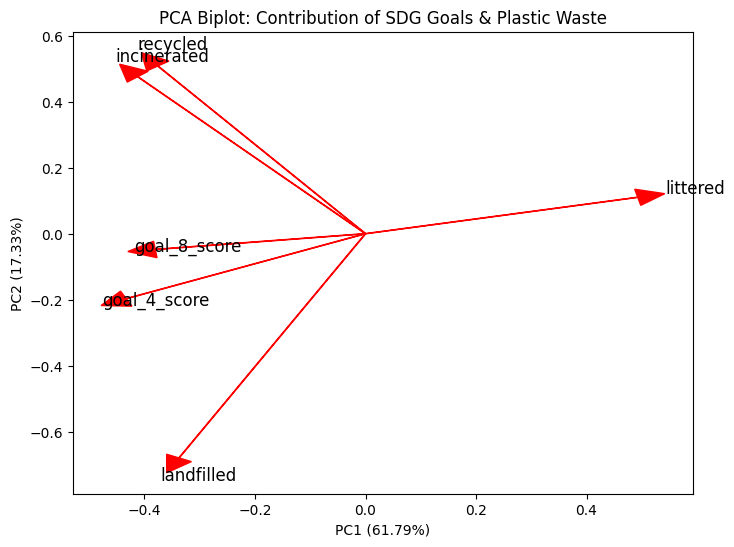

In [10]:
#Machine leraning unsupervised: PCA 

features = ['goal_4_score', 'goal_8_score', 'recycled', 'incinerated', 'littered', 'landfilled']
df_pca = merged_df[features].dropna() 

# Standardize the data (PCA is affected by scale)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

pca = PCA(n_components=2)  
pca_result = pca.fit_transform(scaled_data)

# Convert results into a DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['continent'] = merged_df['continent'].iloc[df_pca.index]  # Keep continent info for coloring

# === Explained Variance ===
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Principal Components:", explained_variance)


# === Biplot to Show Feature Contributions ===
def biplot(pca, features, ax):
    components = pca.components_
    for i, feature in enumerate(features):
        ax.arrow(0, 0, components[0, i], components[1, i], head_width=0.05, head_length=0.05, color='r')
        ax.text(components[0, i] * 1.1, components[1, i] * 1.1, feature, fontsize=12)
        

fig, ax = plt.subplots(figsize=(8, 6))
biplot(pca, features, ax)
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.title("PCA Biplot: Contribution of SDG Goals & Plastic Waste")
plt.grid(False)
plt.show()


In [11]:
print("Explained Variance by Principal Components:", explained_variance)


Explained Variance by Principal Components: [0.61791994 0.17328461]


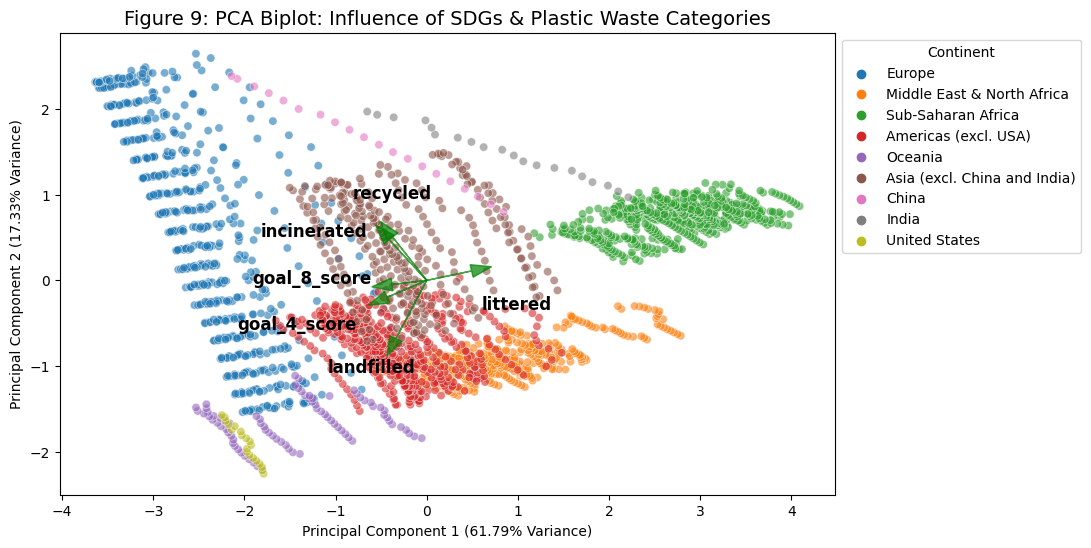

In [20]:


# ===== Features for PCA =====
features = ["goal_4_score", "goal_8_score", "recycled", "incinerated", "littered", "landfilled"]
df_numeric = merged_df[features].dropna()

# ===== Standardize Data (PCA Requires Normalized Data) =====
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)


pca = PCA(n_components=2) 
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["continent"] = merged_df["continent"].values  # Add continent info back

# ===== Explained Variance =====
explained_variance = pca.explained_variance_ratio_

# ===== Biplot Function with Better Text Positioning =====
def biplot(pca, features, ax):
    loadings = pca.components_.T
    text_offsets = {  # Adjust offsets for readability
        "recycled": (1.0, 2.0),
        "incinerated": (3.0, 1.2),
        "littered": (2.0, -2.5),
        "landfilled": (1.8, 1.5),
        "goal_4_score": (3.3, 2.6),
        "goal_8_score": (3.3, -0.6),
    }
    
    for i, feature in enumerate(features):
        ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                 color="green", alpha=0.7, head_width=0.15)
        
        offset_x, offset_y = text_offsets.get(feature, (1.5, 1.5))  # Default offset if not specified
        ax.text(loadings[i, 0] * offset_x, loadings[i, 1] * offset_y, feature, 
                color="black", ha='center', va='center', fontsize=12, weight='bold')

# ===== Plot PCA Biplot =====
plt.figure(figsize=(10, 6))
ax = plt.gca()

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="continent", alpha=0.6, ax=ax)

biplot(pca, features, ax)  # Add arrows and text labels

plt.title("Figure 9: PCA Biplot: Influence of SDGs & Plastic Waste Categories", fontsize=14)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)")
plt.legend(title="Continent", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(False)
